In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
pd.set_option('display.max_columns', 30)

run_o3a_raw = pd.read_csv('../data/gspy_o3a.csv')

#Sorting GPSTime From Lowest To Highest
run_o3a_sorted = run_o3a_raw.sort_values('GPStime', ascending = True)

#Creating The Boolean Confidence Filter
high_confidence = run_o3a_sorted['confidence'] >= .95
run_o3a_sorted = run_o3a_sorted[high_confidence].reset_index()

run_o3a_sorted.head()

,index,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,id,ifo,label,imgUrl,Q-value
0,34471,1238166093,29.137,8.283,1.620000e-22,3030.517,2.000,6025.133301,0,0,1.000,JV8qKKrOkU,L1,Scattered_Light,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,11.314
1,97715,1238166112,33.054,8.694,1.190000e-22,2244.578,0.563,4444.666504,0,0,0.993,kQiZrddHBZ,L1,Scattered_Light,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,11.314
2,117563,1238166130,29.138,8.116,1.770000e-22,32.288,0.250,20.087000,0,0,0.978,qrkZWjcXyF,L1,None_of_the_Above,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,11.314
3,43555,1238166248,35.306,9.917,1.520000e-22,3493.359,1.529,6942.229004,0,0,1.000,lZ4TUoEAE0,L1,Scattered_Light,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,11.314
4,61582,1238166252,42.534,13.919,1.380000e-22,51.401,1.375,58.312511,0,0,1.000,tQizpTlt2V,L1,Scattered_Light,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,11.314


In [4]:
from datetime import datetime, timedelta

#Conversion Function From GPS To UTC --> Returns Object
def gps_to_utc(gps_time):
    utc = datetime(1980, 1, 6) + timedelta(seconds = gps_time - (37 - 19))
    #Reference Consulted For Leap Seconds http://hpiers.obspm.fr/eop-pc/index.php?index=TAI-UTC_tab&lang=en
    time_string = utc.strftime("%m/%d/%Y, %H:%M:%S")
    return time_string

#Creating A New Dataframe
gps_time_df = run_o3a_sorted[['GPStime']]
#Converting Int64 To Object
gps_time_df = gps_time_df.GPStime.astype(object)

#Using The Apply Method To Convert The Time
gps_time_df = gps_time_df.apply(gps_to_utc)

In [5]:
#Converting The Series Into A Dataframe
gps_time_df = gps_time_df.to_frame()
#Renaming GPS Time Column To UTC Time
gps_time_df = gps_time_df.rename(columns = {"GPStime": "UTC Time"})

In [6]:
#Adding Custom Columns To The Dataframe
gps_time_df['Label'] = run_o3a_sorted['label']
gps_time_df['Duration'] = run_o3a_sorted['duration']
gps_time_df['Q-Value'] = run_o3a_sorted['Q-value']
gps_time_df['Confidence'] = run_o3a_sorted['confidence']
gps_time_df

,UTC Time,Label,Duration,Q-Value,Confidence
0,"04/01/2019, 15:01:15",Scattered_Light,2.000,11.314,1.000
1,"04/01/2019, 15:01:34",Scattered_Light,0.563,11.314,0.993
2,"04/01/2019, 15:01:52",None_of_the_Above,0.250,11.314,0.978
3,"04/01/2019, 15:03:50",Scattered_Light,1.529,11.314,1.000
4,"04/01/2019, 15:03:54",Scattered_Light,1.375,11.314,1.000
...,...,...,...,...,...
134165,"10/01/2019, 13:16:52",Koi_Fish,2.500,5.657,0.967
134166,"10/01/2019, 13:21:00",Low_Frequency_Burst,1.000,11.314,0.999
134167,"10/01/2019, 13:55:37",Repeating_Blips,2.507,5.657,0.953
134168,"10/01/2019, 14:17:09",Koi_Fish,1.500,5.657,0.999


In [16]:
#Creating A 1 Column Dataframe From Run_O3A_Sorted
average_glitches = run_o3a_sorted
average_glitches = average_glitches['GPStime']
#Changing The GPS Times To Intervals Of 60 Seconds --> Will Have To Cut Bottom Rows Later On
previous_value = 0
average_glitches[0] = 0

for k in range(1, len(average_glitches)):
    average_glitches[k] = previous_value + 60
    previous_value = previous_value + 60
#Converting To A Dataframe
average_glitches = average_glitches.to_frame()

In [25]:
#Creating A 2nd Column For Glitch Count
average_glitches["Glitch Count"] = average_glitches["GPStime"]

#Setting All Glitch Counts To Zero
for k in range(1, len(average_glitches)):
    average_glitches.iloc[k,1] = 0

In [47]:
end_index = 0
start_index = 1238166093

for k in range(1,264):
    end_index = start_index + 60  
    filter = run_o3a_sorted['GPStime'].between(start_index, end_index)
    average_glitches.iloc[k,1] = len(run_o3a_sorted[filter])
    start_index = end_index

In [56]:
average_glitches = average_glitches.iloc[0:265]
average_glitches

,GPStime,Glitch Count
0,0,0
1,60,3
2,120,0
3,180,9
4,240,0
...,...,...
260,15600,0
261,15660,0
262,15720,1
263,15780,0


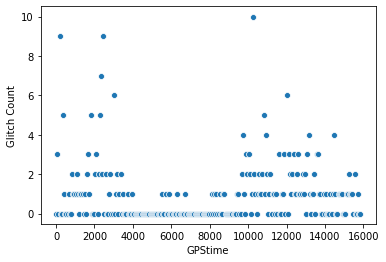

In [57]:
plot = sns.scatterplot(x = 'GPStime', y = "Glitch Count", data = average_glitches)

In [ ]:
#Creating A Scatterplot With A Hue


In [87]:
#Creating An Array Of Unique Glitch Names
label_names = run_o3a_sorted['label'].unique()

for k in range(0, len(label_names)):
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [119]:
earthquakes = pd.read_csv('../data/all_day.csv', parse_dates = ['time'])
earthquakes.sort_values('mag', ascending = False).head()
earthquakes.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2020-06-12 02:12:58+00:00,35.700167,-117.456333,1.48,1.49,ml,19.0,91.00,0.1627,0.18,ci,ci39475784,2020-06-12T02:16:37.152Z,"9km SSW of Searles Valley, CA",earthquake,0.41,0.68,0.156,21.0,automatic,ci,ci
1,2020-06-12 02:07:50.830000+00:00,35.632833,-117.407667,10.42,1.42,ml,17.0,159.00,0.1132,0.14,ci,ci39475776,2020-06-12T02:11:33.120Z,"15km S of Trona, CA",earthquake,0.44,0.83,0.184,21.0,automatic,ci,ci
2,2020-06-12 01:57:06.180000+00:00,35.579333,-117.647000,12.99,1.44,ml,17.0,79.00,0.1036,0.22,ci,ci39475768,2020-06-12T02:00:53.062Z,"5km SSE of Ridgecrest, CA",earthquake,0.48,1.14,0.195,24.0,automatic,ci,ci
3,2020-06-12 01:51:36.620000+00:00,38.169200,-117.940000,8.70,1.70,ml,17.0,94.89,0.0510,0.15,nn,nn00747304,2020-06-12T01:59:49.443Z,"28 km SSE of Mina, Nevada",earthquake,NaN,0.70,NaN,NaN,automatic,nn,nn
4,2020-06-12 01:50:05.608000+00:00,62.393900,-148.158400,22.70,1.70,ml,NaN,NaN,NaN,0.82,ak,ak0207j912uv,2020-06-12T01:53:24.543Z,"68 km NNE of Chickaloon, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
